1. https://mobidev.biz/blog/machine-learning-methods-demand-forecasting-retail

2.https://www.mygreatlearning.com/blog/how-machine-learning-is-used-in-sales-forecasting/

3.https://medium.com/@chunduri11/deep-learning-part-1-fast-ai-rossman-notebook-7787bfbc309f

4.https://www.kaggle.com/anshuls235/time-series-forecasting-eda-fe-modelling

5.https://eng.uber.com/neural-networks/

6.https://www.kaggle.com/mayer79/m5-forecast-keras-with-categorical-embeddings-v2

# Problem Statement:

We here have a hierarchical data for products for Walmart store for different categories from three states namely, California, Winscoin and Texas. Looking at this data we need to predict the sales for the products for 28 days. The training data that we have consist of individual sales for each product for 1914 days. Using this train data we need to make prediction on the next days.

We have the following files provided from as the part of the competition:

1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

Using this dataset we need to make the sales prediction for the next 28 days.

# Doing Necessary Imports

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import OrdinalEncoder
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import pywt

In [2]:
os.listdir('C:\M5 Forecasting')

['calendar.csv',
 'sales_train_evaluation.csv',
 'sales_train_evaluation.csv.zip',
 'sales_train_validation.csv',
 'sales_train_validation.csv.zip',
 'sample_submission.csv',
 'sample_submission.csv.zip',
 'sell_prices.csv',
 'sell_prices.csv.zip']

# Importing Data

In [3]:
calendar_pd=pd.read_csv('C:\M5 Forecasting\calendar.csv')
sales_train_eval_pd=pd.read_csv('C:\M5 Forecasting\sales_train_evaluation.csv')
sales_train_valid_pd=pd.read_csv('C:\M5 Forecasting\sales_train_validation.csv')
sell_price_pd=pd.read_csv('C:\M5 Forecasting\sell_prices.csv')
submission=pd.read_csv('C:\M5 Forecasting\sample_submission.csv')

# Calendar DataFrame

In [4]:
print('*********************Calendar Dataframe*******************',calendar_pd.shape)
calendar_pd.head()

*********************Calendar Dataframe******************* (1969, 14)


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


# Sales Evaluation Dataframe

In [5]:
print('*********************Sales Train Evaluation Dataframe*******************',sales_train_eval_pd.shape)
sales_train_eval_pd.head()

*********************Sales Train Evaluation Dataframe******************* (30490, 1947)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


# Sales_Validation Dataframe

In [6]:
print('*********************Sales Train Validation Dataframe*******************',sales_train_valid_pd.shape)
sales_train_valid_pd.head()

*********************Sales Train Validation Dataframe******************* (30490, 1919)


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


# Sell_Price Dataframe

In [7]:
print('*********************Sell Prices Dataframe*******************',sell_price_pd.shape)
sell_price_pd.head()

*********************Sell Prices Dataframe******************* (6841121, 4)


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


# Sample Submission DataFrame

In [8]:
print(submission.shape)
submission.head()

(60980, 29)


,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Exploratory Data Analysis

Now, let us begin abalyzing these datasets and see if we could find any kind of patterns. Let us begin with the calendar data that we have

# Calendar Data EDA

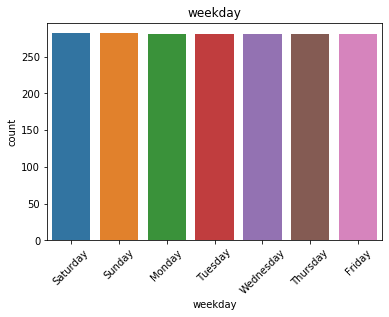

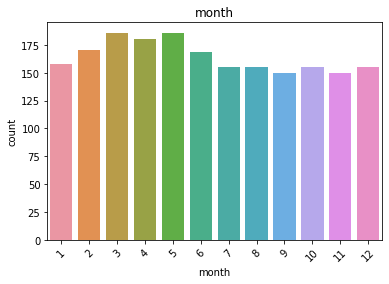

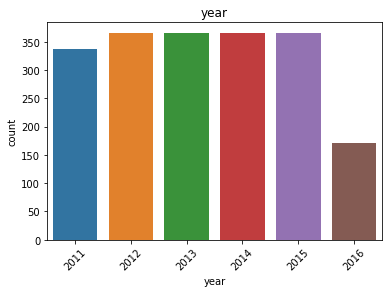

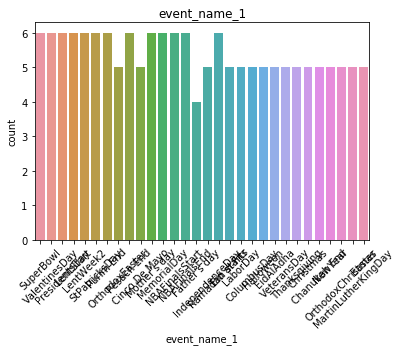

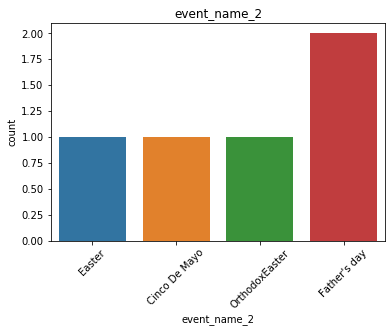

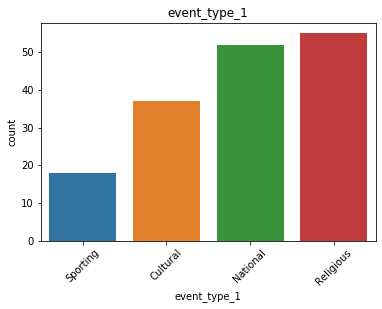

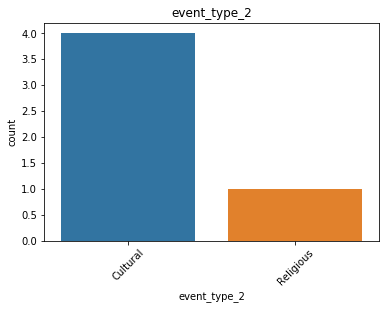

In [9]:
for col in ['weekday','month','year','event_name_1','event_name_2','event_type_1','event_type_2']:
    sns.countplot(calendar_pd[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()

# Observations from Calendar Dataframe:

1. We have data for all the weekdays with equal counts. Hence, it is safe to say we do not have any kind of missing entries here.

2. We have higher count of values for the month of March, April and May. For the last quarter the count is low

3. We have data from 2011 to 2016. Although we don't have the data for all the days of 2016. This explains the higher count of values for the first few months.

4. We also have a list of events, that might be useful in analyzing trends and patterns in our data.

5. We have more data for cultural events rather than religious events


# Sales Validation Data EDA

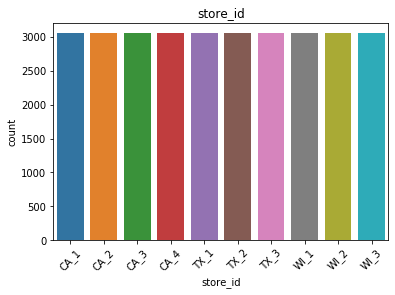

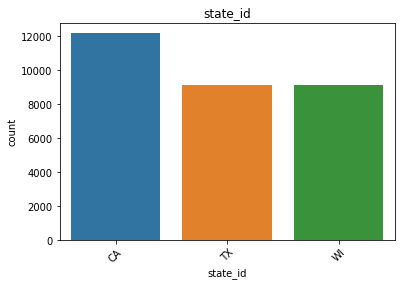

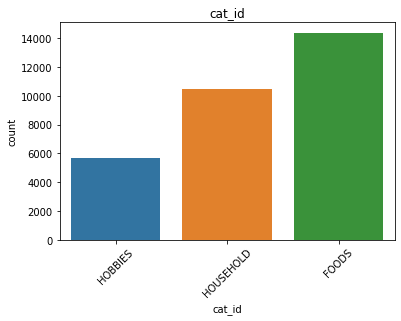

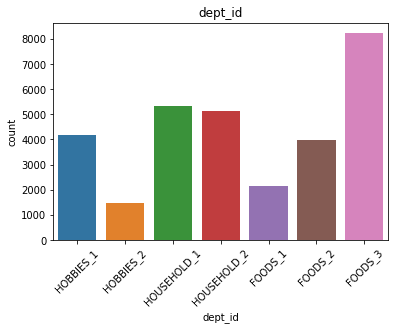

In [10]:
for col in ['store_id','state_id','cat_id','dept_id']:
    sns.countplot(sales_train_valid_pd[col])
    plt.title(col)
    plt.xticks(rotation=45)
    plt.show()
   
    

# Observations from Sales Data:

1. We have data for three different categories which are Household, Food and Hobbies
2. We have data for three different states California, Wiscosin and Texas
3. Sales for Foods is maximum

# Analyzing Sales Pattern:

Now, let us have a look randomly at few products and see if there are any patterns corresponding to their weekly, monthly or yearly sales.

In [11]:
#taking all days for which we have the data for product sold
d_cols=[ele for ele in sales_train_valid_pd.columns if 'd_' in ele]

# Randomly Selected Product Sales Plots

Text(0.5, 1.0, 'HOBBIES_1_001_CA_1_validation')

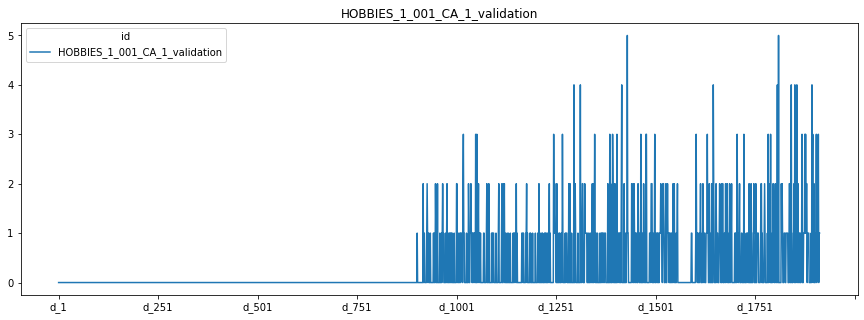

In [12]:
#purchase for all the days for the product HOBBIES_1_001_CA_1_validation

sales_train_valid_pd.loc[sales_train_valid_pd['id']=='HOBBIES_1_001_CA_1_validation'].set_index('id')[d_cols].T.plot(figsize=(15, 5))
plt.title('HOBBIES_1_001_CA_1_validation')

From the aboe plot we see that till day_800 there are no sales for this particualr product. That might be because the product was intrdocued in market later. After that the products sales went up and down.

Text(0.5, 1.0, 'FOODS_3_090_CA_3_validation')

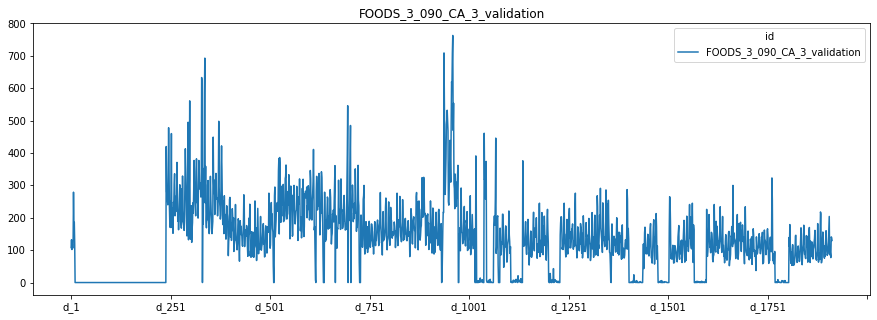

In [13]:
#purchase for all the days for the product FOODS_3_090_CA_3_validation

sales_train_valid_pd.loc[sales_train_valid_pd['id']=='FOODS_3_090_CA_3_validation'].set_index('id')[d_cols].T.\
plot(figsize=(15, 5))
plt.title('FOODS_3_090_CA_3_validation')

For this product after day1 there was a steep down in sales. But from day251 there has been an increase and decrease of sales.

Text(0.5, 1.0, 'HOUSEHOLD_2_348_CA_1_validation')

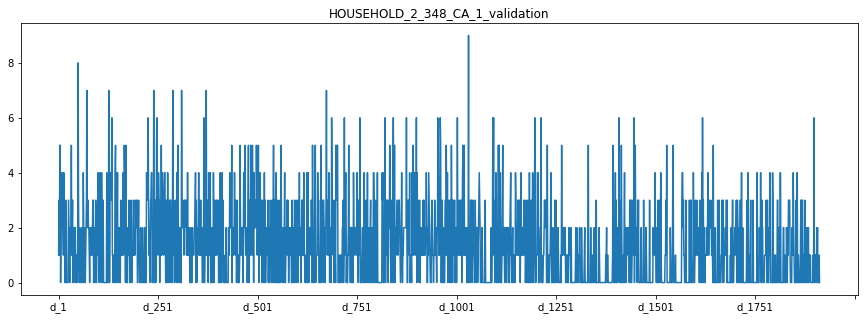

In [14]:
num=random.choice(list(range(1,30490)))
sales_train_valid_pd.loc[num][d_cols].T.plot(figsize=(15, 5))
plt.title(sales_train_valid_pd.loc[num].id)

Seeing this graph also we can say that this particualr product was introduced in market after day750. As we see that after that there is a rise in sales, and till that day the sales have been zero

Text(0.5, 1.0, 'FOODS_3_325_TX_3_validation')

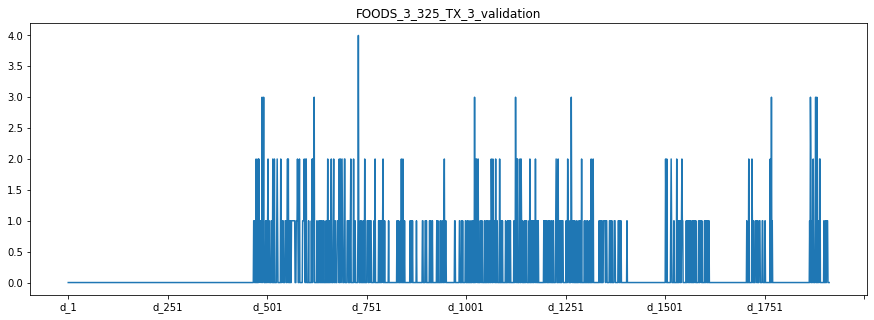

In [15]:
num=random.choice(list(range(20000,30490)))
sales_train_valid_pd.loc[num][d_cols].T.plot(figsize=(15, 5))
plt.title(sales_train_valid_pd.loc[num].id)

Seeing this graph also we can say that this particualr product was introduced in market after day500. As we see that after that there is a rise in sales, and till that day the sales have been zero. Aftet this day the sales for this product shows a fluctuating pattern which does not seem to change much over time, apart from the fact that on few days the sales hit the maximum value then expected.

# Merge Example with Calendar data

Now, so far we have seen the patterns on the day_count. Let us combine the same with caledar data and see if we find any trends. Seeing the distribution by merging on calendar data

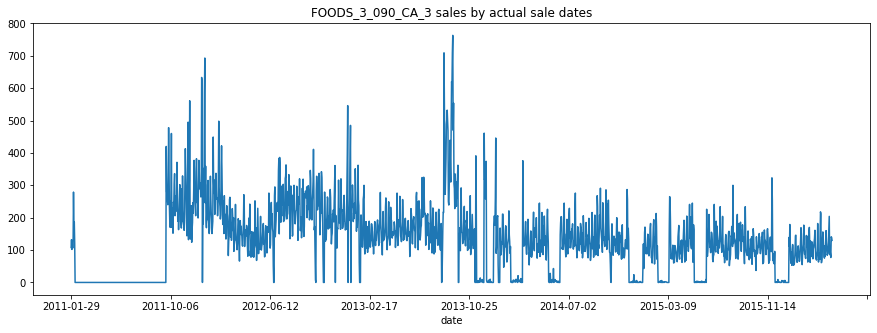

In [16]:
example1 = sales_train_valid_pd.loc[sales_train_valid_pd['id'] == 'FOODS_3_090_CA_3_validation'][d_cols].T
example1=example1.rename(columns={8412:'FOODS_3_090_CA_3_validation'})
example1 = example1.reset_index().rename(columns={'index': 'd'})
example1 = example1.merge(calendar_pd, how='left', validate='1:1')
example1.set_index('date')['FOODS_3_090_CA_3_validation'].plot(figsize=(15, 5))
plt.title('FOODS_3_090_CA_3 sales by actual sale dates')
plt.show()

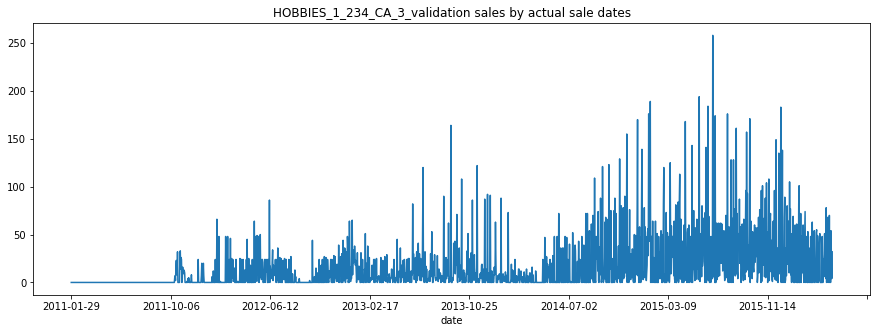

In [17]:
example2 = sales_train_valid_pd.loc[sales_train_valid_pd['id'] == 'HOBBIES_1_234_CA_3_validation'][d_cols].T
example2=example2.rename(columns={6324:'HOBBIES_1_234_CA_3_validation'})
example2 = example2.reset_index().rename(columns={'index': 'd'})
example2 = example2.merge(calendar_pd, how='left', validate='1:1')
example2.set_index('date')['HOBBIES_1_234_CA_3_validation'].plot(figsize=(15, 5))
plt.title('HOBBIES_1_234_CA_3_validation sales by actual sale dates')
plt.show()

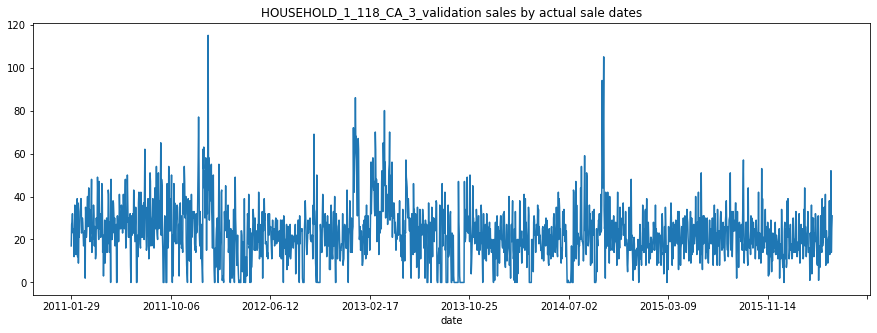

In [18]:
example3 = sales_train_valid_pd.loc[sales_train_valid_pd['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3=example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3_validation'})
example3 = example3.reset_index().rename(columns={'index': 'd'})
example3 = example3.merge(calendar_pd, how='left', validate='1:1')
example3.set_index('date')['HOUSEHOLD_1_118_CA_3_validation'].plot(figsize=(15, 5))
plt.title('HOUSEHOLD_1_118_CA_3_validation sales by actual sale dates')
plt.show()

In [51]:
example3['HOUSEHOLD_1_118_CA_3_validation']

,d,HOUSEHOLD_1_118_CA_3_validation,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,d_1,17,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,d_2,27,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,d_3,28,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,d_4,32,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,d_5,24,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1


# Breaking down the time Variables

We can break down according to the day of the week, month and year to see if there exists any kind of pattern

# Day, Month & Yearly Avg Sales for HOUSEHOLD_1_118_CA_3_validation

Text(0.5, 1.0, 'Avg week sales for HOUSEHOLD_1_118_CA_3_validation ')

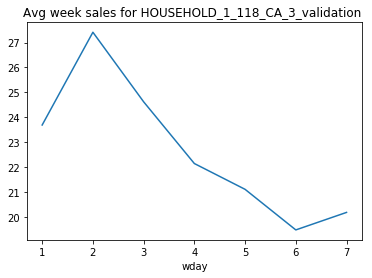

In [19]:
example3 = sales_train_valid_pd.loc[sales_train_valid_pd['id'] == 'HOUSEHOLD_1_118_CA_3_validation'][d_cols].T
example3=example3.rename(columns={6776:'HOUSEHOLD_1_118_CA_3_validation'})
example3 = example3.reset_index().rename(columns={'index': 'd'})
example3 = example3.merge(calendar_pd, how='left', validate='1:1')
example3.set_index('date')['HOUSEHOLD_1_118_CA_3_validation'].plot(figsize=(15, 5))
sample3=example3.groupby('wday').mean()['HOUSEHOLD_1_118_CA_3_validation']
sample3.plot(kind='line')
plt.title('Avg week sales for HOUSEHOLD_1_118_CA_3_validation ')

For this particular product we can see that the sales see a drop after Tuesday and hits minimum on Saturday. 

Text(0.5, 1.0, 'Avg monthly sales for HOUSEHOLD_1_118_CA_3_validation ')

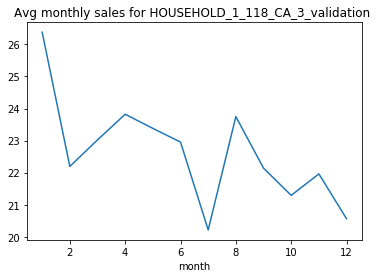

In [20]:
sample3=example3.groupby('month').mean()['HOUSEHOLD_1_118_CA_3_validation']

sample3.plot(kind='line')
plt.title('Avg monthly sales for HOUSEHOLD_1_118_CA_3_validation ')

The monthly sales drop in the middle of the year. After which we can say that it reaches a minimum in 7th month that is July.

Text(0.5, 1.0, 'Avg yearly sales for HOUSEHOLD_1_118_CA_3_validation ')

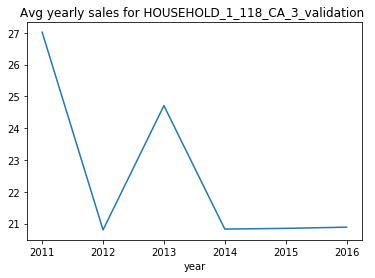

In [21]:
sample3=example3.groupby('year').mean()['HOUSEHOLD_1_118_CA_3_validation']

sample3.plot(kind='line')
plt.title('Avg yearly sales for HOUSEHOLD_1_118_CA_3_validation ')

From the above graph we can see that the sales just dropped to zero from 2013 to 2014. This means that the product might be have been updated with a new product version or just removed from this store. From this plot it will be safe to say that for the days to predict the sales should still be zero.

# Comapring Sales Trends for All three Dfs

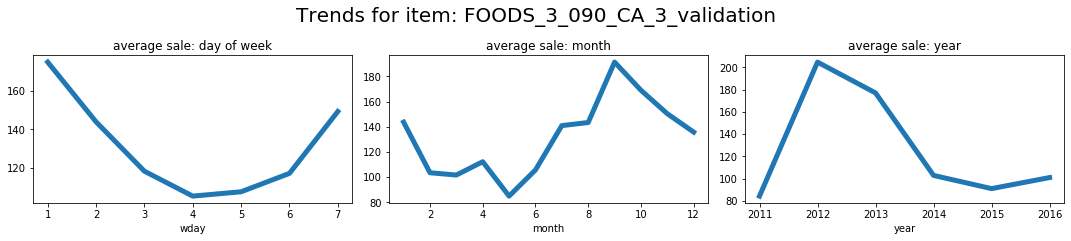

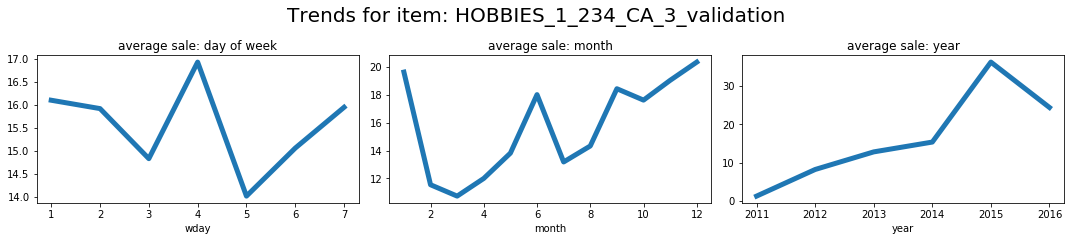

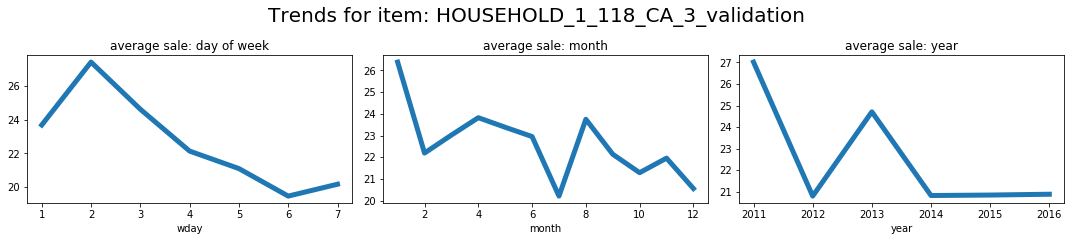

In [22]:
examples = ['FOODS_3_090_CA_3_validation','HOBBIES_1_234_CA_3_validation','HOUSEHOLD_1_118_CA_3_validation']
example_df = [example1, example2, example3]
for i in [0, 1, 2]:
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    example_df[i].groupby('wday').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: day of week',
              lw=5,
              ax=ax1)
    example_df[i].groupby('month').mean()[examples[i]] \
        .plot(kind='line',
              title='average sale: month',
              lw=5, ax=ax2)
    example_df[i].groupby('year').mean()[examples[i]] \
        .plot(kind='line',
              lw=5,
              title='average sale: year',

              ax=ax3)
    fig.suptitle(f'Trends for item: {examples[i]}',
                 size=20,
                 y=1.1)
    plt.tight_layout()
    plt.show()

For these randomly selected products we do not see any relation between the distribution. Every product has its own pattern and we need to find those individua patterns in order to preodict their demand for next 28 days

# Seeing Item Sales Category Wise

In [23]:
sales_train_valid_pd['cat_id'].value_counts()

FOODS        14370
HOUSEHOLD    10470
HOBBIES       5650
Name: cat_id, dtype: int64

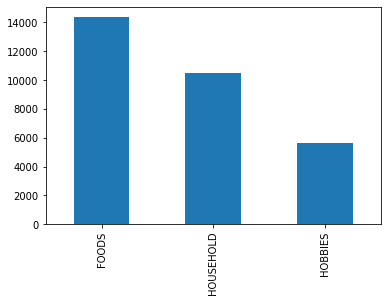

In [24]:
sales_train_valid_pd.cat_id.value_counts().plot(kind='bar')

In [25]:
temp=sales_train_valid_pd.groupby('cat_id').mean().T.reset_index().rename(columns={'index':'d'})\
.merge(calendar_pd[['date','d']],how='left',validate='1:1').set_index('date')
temp.head()

,d,FOODS,HOBBIES,HOUSEHOLD
date,,,,
2011-01-29,d_1,1.612944,0.666195,0.543362
2011-01-30,d_2,1.583716,0.594159,0.538109
2011-01-31,d_3,1.195129,0.474690,0.375072
2011-02-01,d_4,1.313709,0.472389,0.369150
2011-02-02,d_5,1.016214,0.321062,0.260649


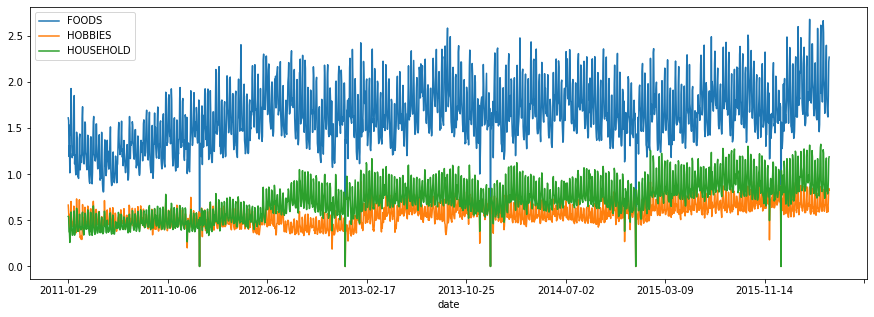

In [26]:
temp.plot(figsize=(15,5))

# Observations:

The sales data for FOOD patterns lie above for that of HOBBIES and HOUSEHOLD, without any overlap. This shows that sales for FOOD are considerably higher than the other two.

# Seeing Sales Per State

Now, let us see the sales pattern category state wise

In [48]:
temp=sales_train_valid_pd.groupby('state_id').mean().T.reset_index().rename(columns={'index':'d'})\
.merge(calendar_pd[['date','d']],how='left',validate='1:1').set_index('date')
temp.head()

,d,CA,TX,WI
date,,,,
2011-01-29,d_1,1.163906,1.031814,0.983711
2011-01-30,d_2,1.131929,1.052804,0.908932
2011-01-31,d_3,0.828796,0.741008,0.754018
2011-02-01,d_4,0.905789,0.806931,0.763529
2011-02-02,d_5,0.813791,0.646332,0.361758


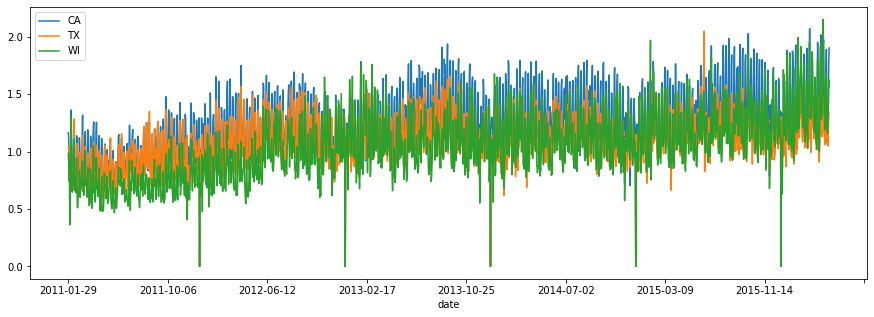

In [28]:
temp.plot(figsize=(15,5))

# Observation:
The sales pattern for three states almost overlap. Hence, there is not much difference between the sales trends for the three states.

# Visualizing Patterns Between Sales for  A Single Category

# Weekly, Monthly, Yearly Sales of Randomly Selected Products in Hobbies

In [29]:
hobbies_df=sales_train_valid_pd[sales_train_valid_pd['cat_id']=='HOBBIES'][['id']+ d_cols].set_index('id').T
hobbies_df=hobbies_df.reset_index().rename(columns={'index':'d'})
hobbies_df=pd.merge(hobbies_df,calendar_pd,how='left',left_on='d',right_on='d').set_index('date')

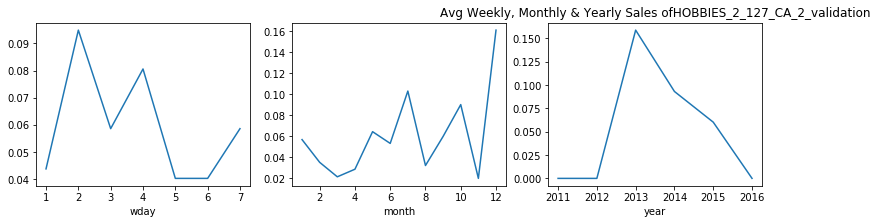

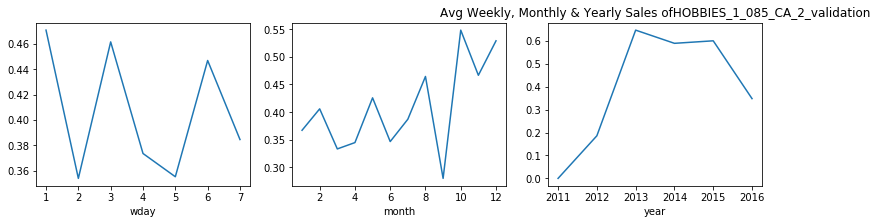

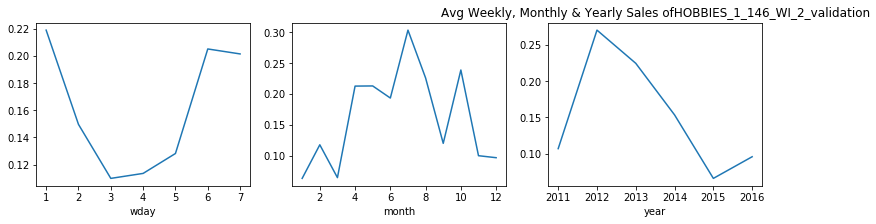

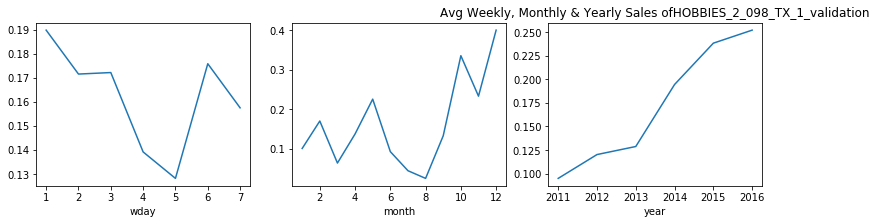

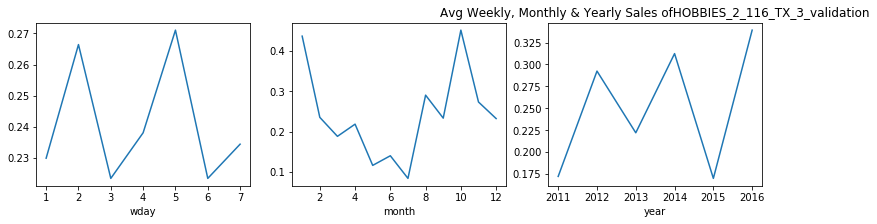

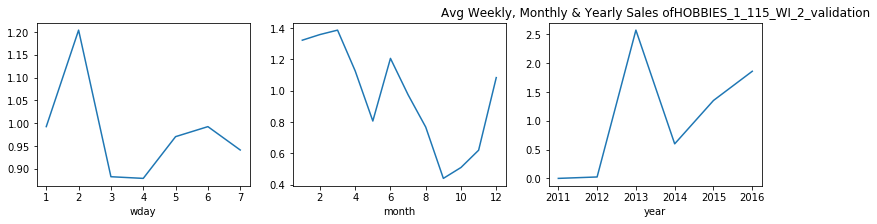

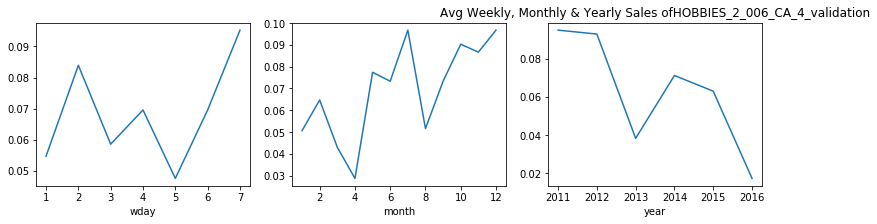

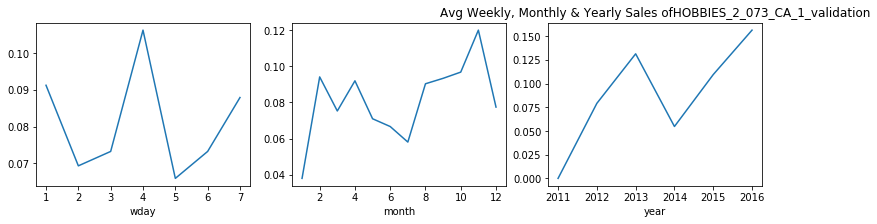

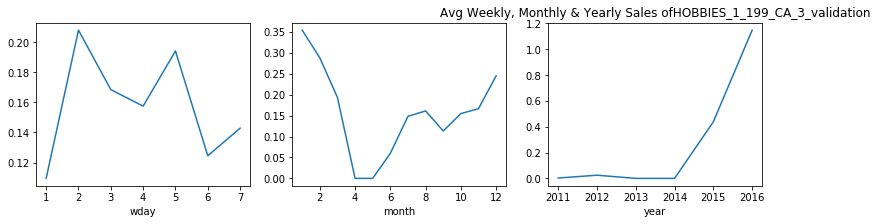

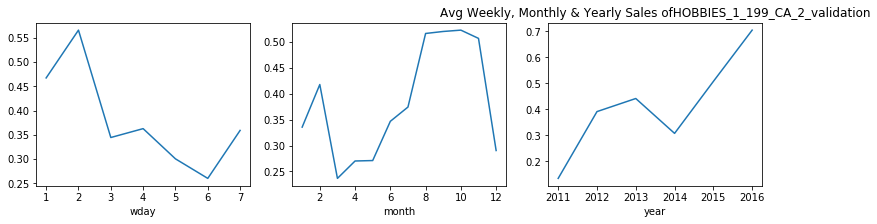

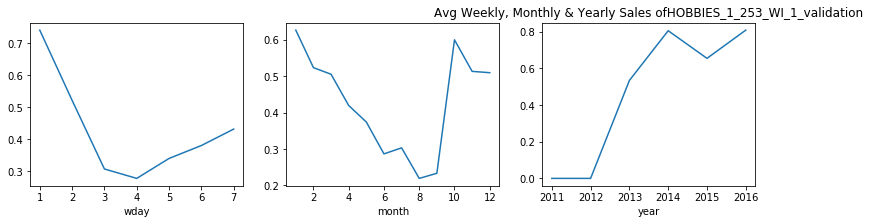

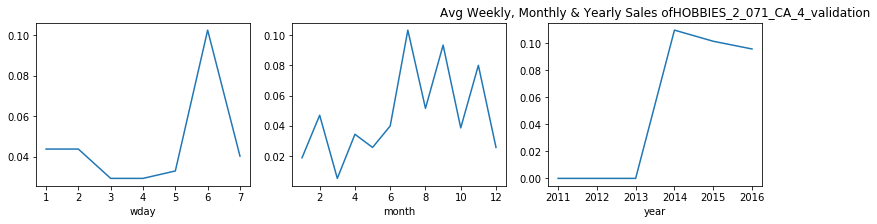

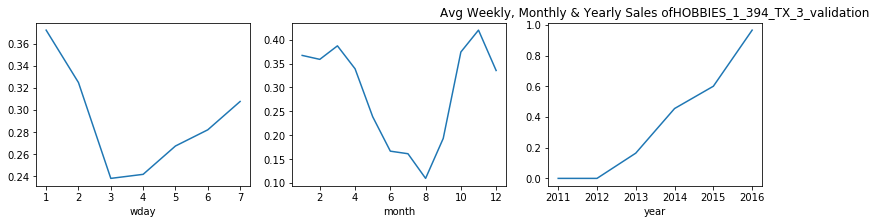

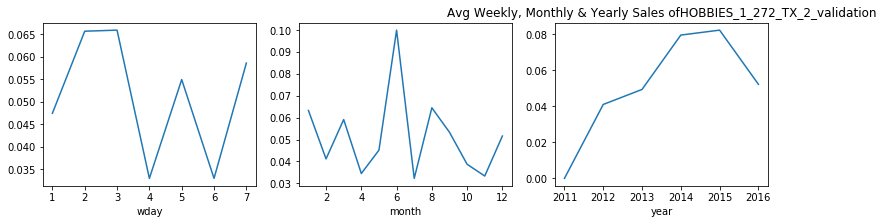

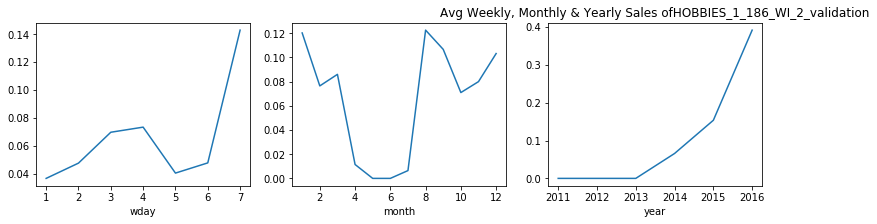

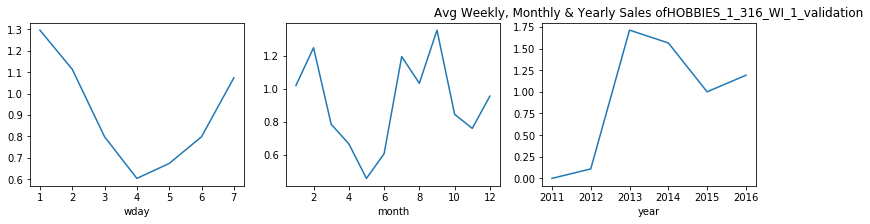

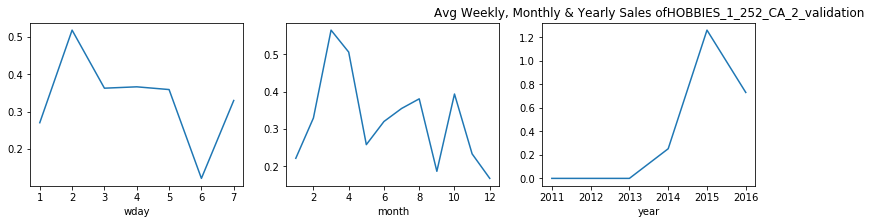

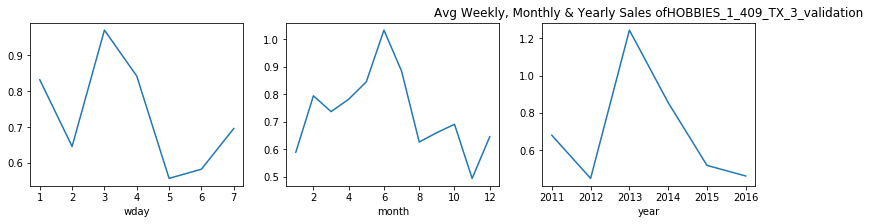

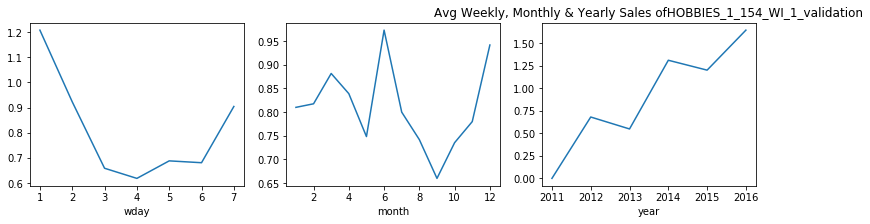

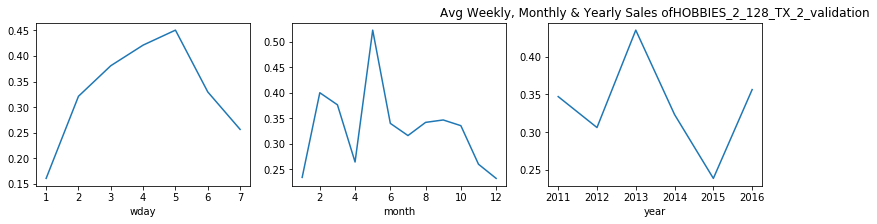

In [30]:
hobbies_pdts=hobbies_df.columns[2:5000]
for i in range(20):
    num=random.choice(list(range(len(hobbies_pdts))))
    fig,axes=plt.subplots(1,3)
    plt.title('Avg Weekly, Monthly & Yearly Sales of'+hobbies_pdts[num])
    hobbies_df.groupby('wday').mean()[hobbies_pdts[num]].plot(ax=axes[0],figsize=(13,3))
    hobbies_df.groupby('month').mean()[hobbies_pdts[num]].plot(ax=axes[1],figsize=(13,3))
    hobbies_df.groupby('year').mean()[hobbies_pdts[num]].plot(ax=axes[2],figsize=(13,3))
    plt.show()

# Observations

From the above plot we see that in meed week usually for 4th and 5th day, the sales drop especially in the case when states are 'WI' and 'TX'. Let us analyze the results on indivdual states to see this more clearly

# Weekly, Monthly, Yearly Sales of Randomly Selected Products in Hobbies in WI

In [31]:
hobbies_wi_df=sales_train_valid_pd[sales_train_valid_pd['cat_id']=='HOBBIES'][sales_train_valid_pd['state_id']=='WI']\
[['id']+ d_cols].set_index('id').T
hobbies_wi_df=hobbies_wi_df.reset_index().rename(columns={'index':'d'})
hobbies_wi_df=pd.merge(hobbies_wi_df,calendar_pd,how='left',left_on='d',right_on='d').set_index('date')

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


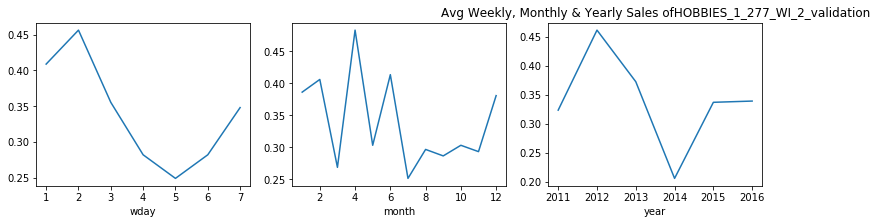

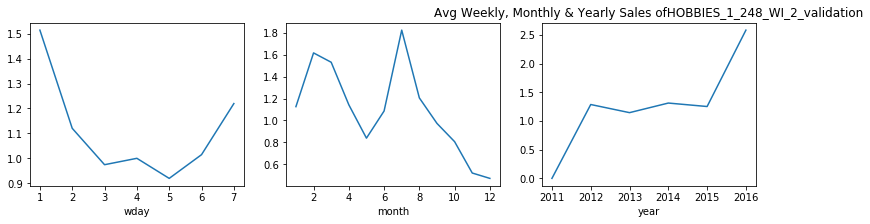

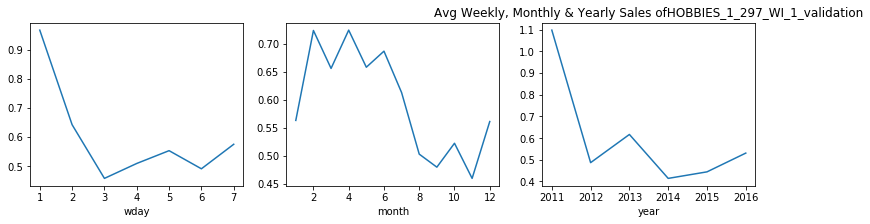

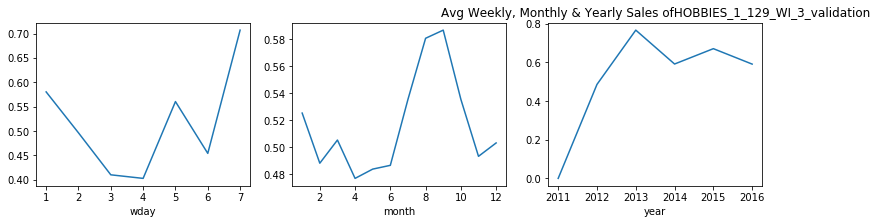

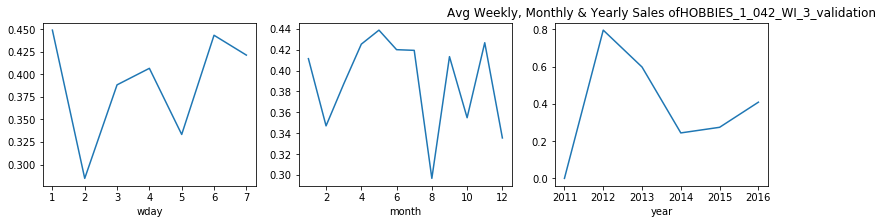

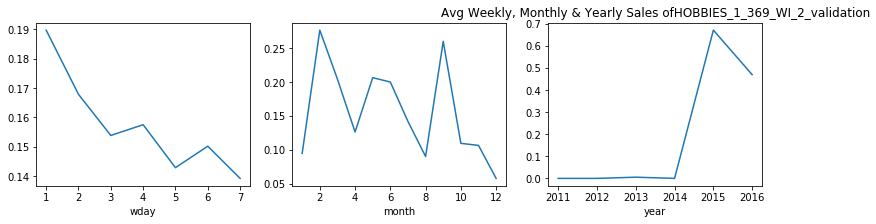

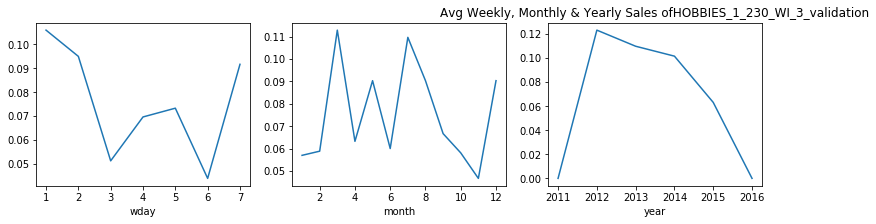

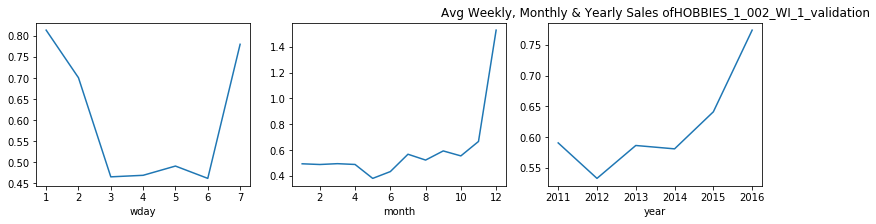

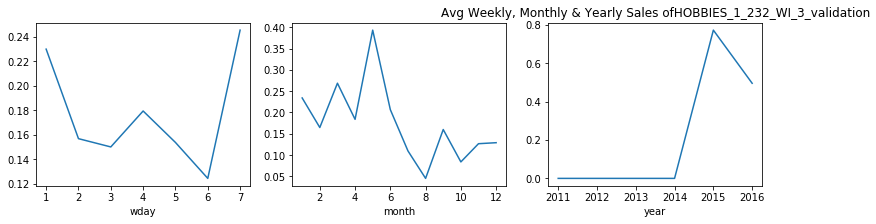

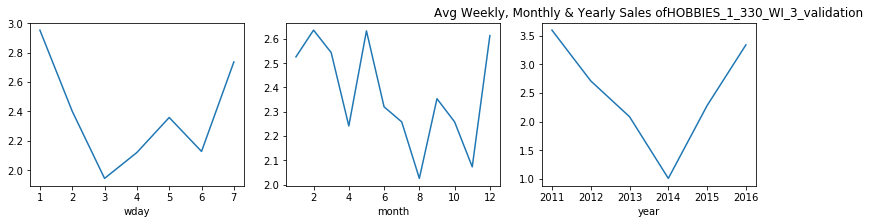

In [32]:
hobbies_pdts=hobbies_wi_df.columns[2:1900]
for i in range(10):
    num=random.choice(list(range(len(hobbies_pdts))))
    fig,axes=plt.subplots(1,3)
    plt.title('Avg Weekly, Monthly & Yearly Sales of'+hobbies_pdts[num])
    hobbies_wi_df.groupby('wday').mean()[hobbies_pdts[num]].plot(ax=axes[0],figsize=(13,3))
    hobbies_wi_df.groupby('month').mean()[hobbies_pdts[num]].plot(ax=axes[1],figsize=(13,3))
    hobbies_wi_df.groupby('year').mean()[hobbies_pdts[num]].plot(ax=axes[2],figsize=(13,3))
    plt.show()

# Observations:

From the above plots we can see that in the state of Wiscosin, for most of the products the sales decrease consdierably in mid-week.

# Weekly, Monthly, Yearly Sales of Randomly Selected Products in Hobbies in CA

In [33]:
hobbies_ca_df=sales_train_valid_pd[sales_train_valid_pd['cat_id']=='HOBBIES'][sales_train_valid_pd['state_id']=='CA']\
[['id']+ d_cols].set_index('id').T
hobbies_ca_df=hobbies_ca_df.reset_index().rename(columns={'index':'d'})
hobbies_ca_df=pd.merge(hobbies_ca_df,calendar_pd,how='left',left_on='d',right_on='d').set_index('date')

C:\Users\mansi.choudhary\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


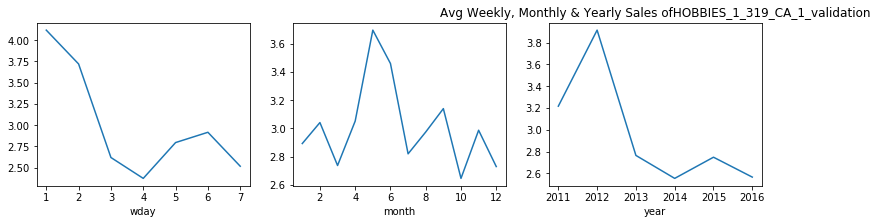

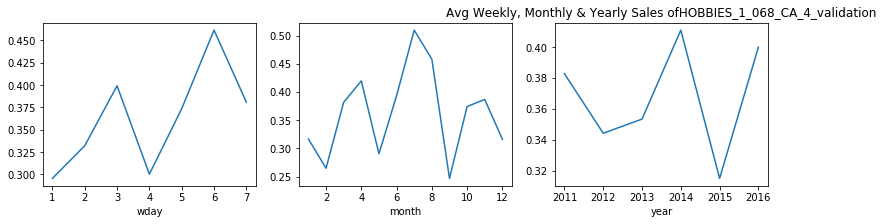

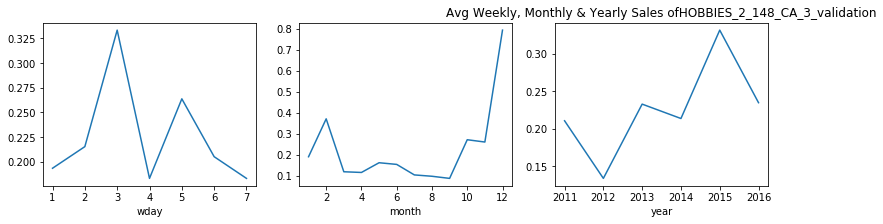

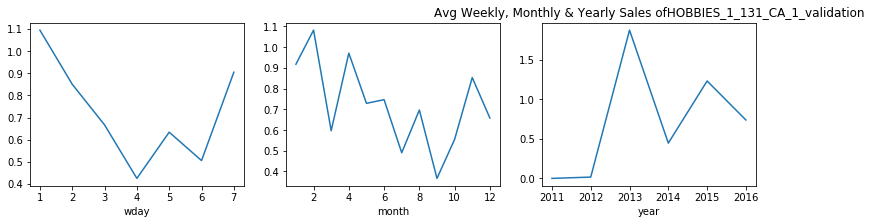

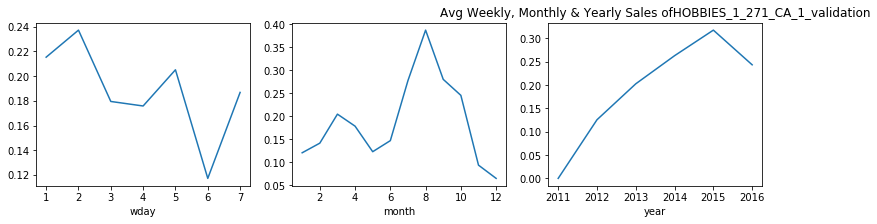

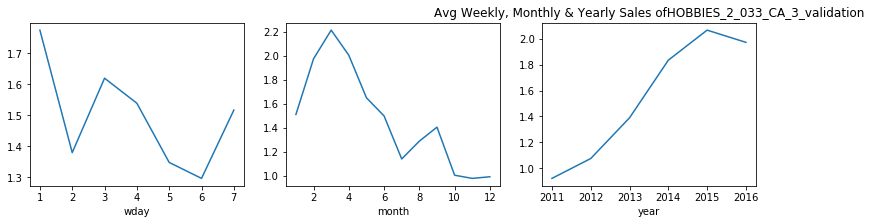

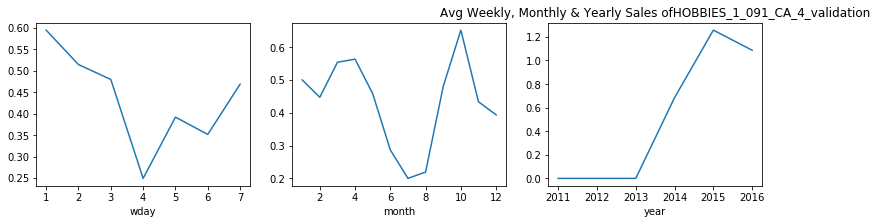

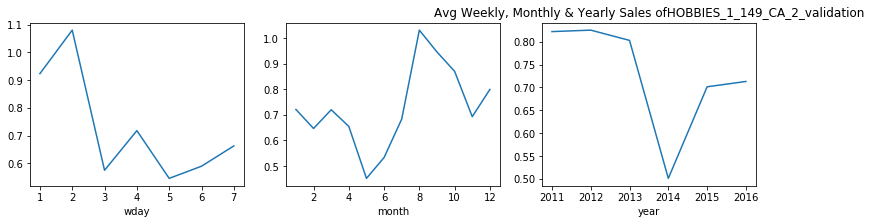

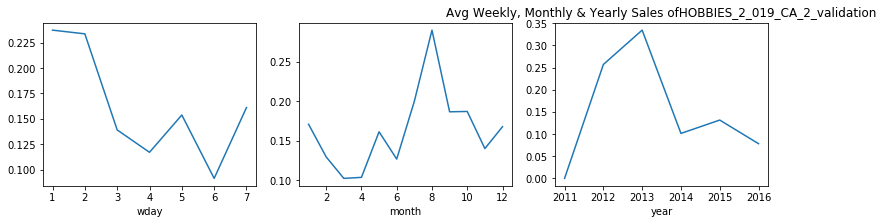

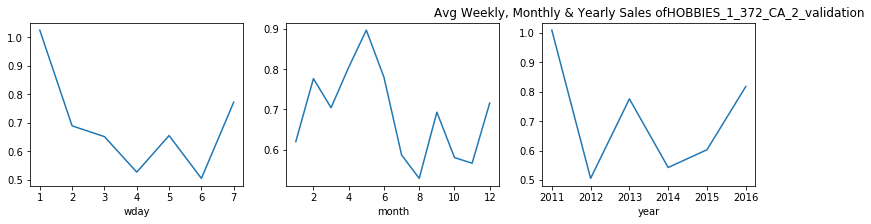

In [34]:
hobbies_pdts=hobbies_ca_df.columns[2:1900]
for i in range(10):
    num=random.choice(list(range(len(hobbies_pdts))))
    fig,axes=plt.subplots(1,3)
    plt.title('Avg Weekly, Monthly & Yearly Sales of'+hobbies_pdts[num])
    hobbies_ca_df.groupby('wday').mean()[hobbies_pdts[num]].plot(ax=axes[0],figsize=(13,3))
    hobbies_ca_df.groupby('month').mean()[hobbies_pdts[num]].plot(ax=axes[1],figsize=(13,3))
    hobbies_ca_df.groupby('year').mean()[hobbies_pdts[num]].plot(ax=axes[2],figsize=(13,3))
    plt.show()

# Weekly, Monthly, Yearly Sales of Randomly Selected Products in Food

In [35]:
foods_df=sales_train_valid_pd[sales_train_valid_pd['cat_id']=='FOODS'][['id']+ d_cols].set_index('id').T
foods_df=foods_df.reset_index().rename(columns={'index':'d'})
foods_df=pd.merge(foods_df,calendar_pd,how='left',left_on='d',right_on='d').set_index('date')

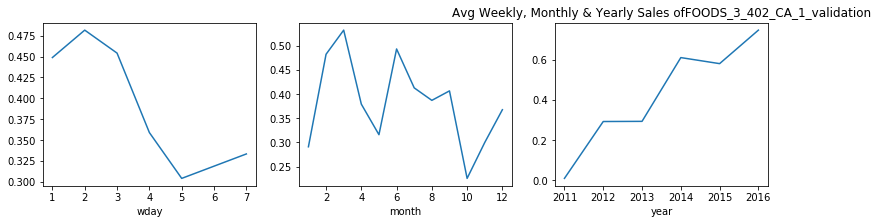

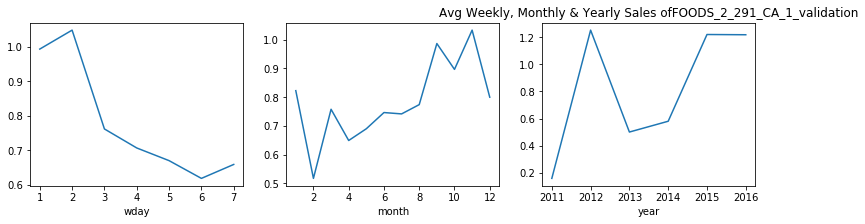

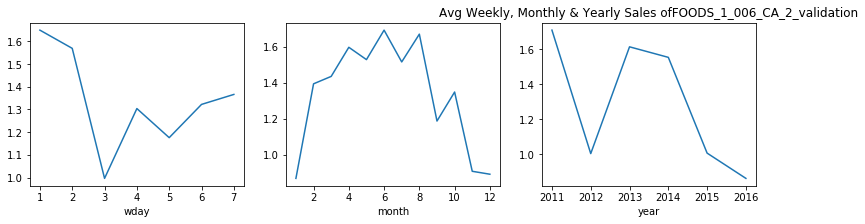

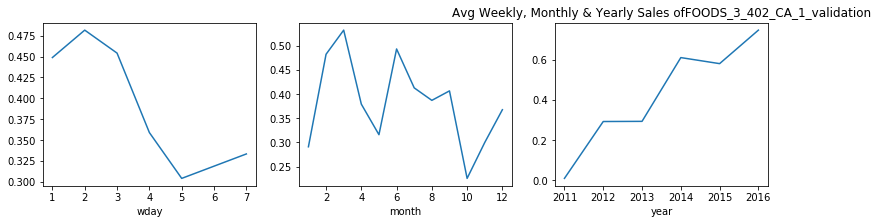

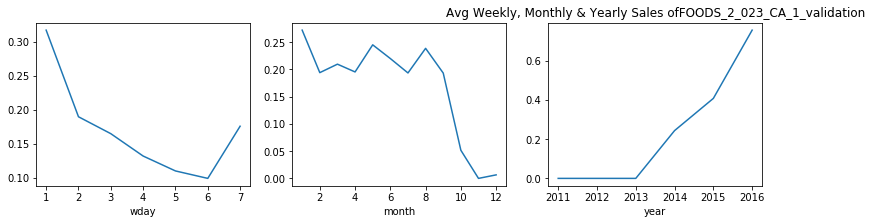

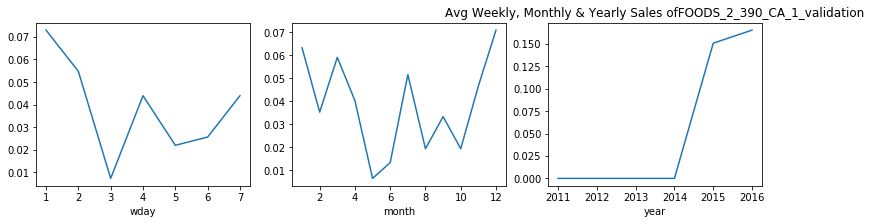

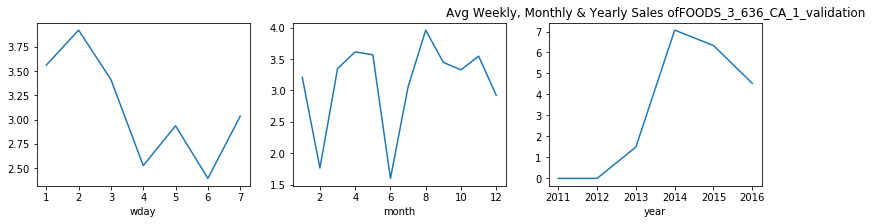

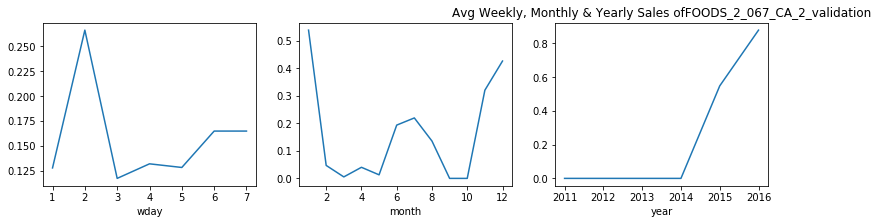

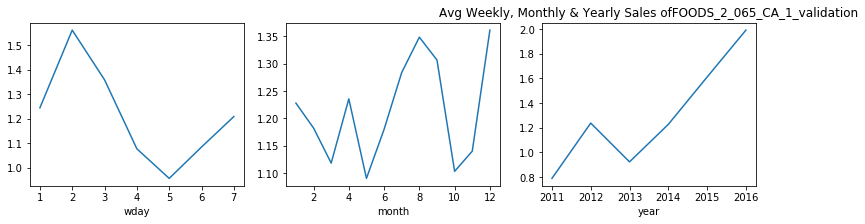

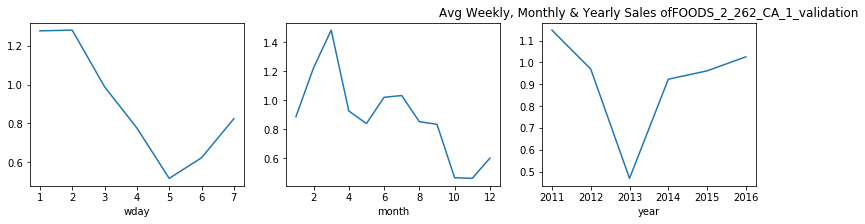

In [36]:
foods_pdts=foods_df.columns[2:5000]
for i in range(10):
    num=random.choice(list(range(len(hobbies_pdts))))
    fig,axes=plt.subplots(1,3)
    plt.title('Avg Weekly, Monthly & Yearly Sales of'+foods_pdts[num])
    foods_df.groupby('wday').mean()[foods_pdts[num]].plot(ax=axes[0],figsize=(13,3))
    foods_df.groupby('month').mean()[foods_pdts[num]].plot(ax=axes[1],figsize=(13,3))
    foods_df.groupby('year').mean()[foods_pdts[num]].plot(ax=axes[2],figsize=(13,3))
    plt.show()

# Observation:

From the plots above we can say that in California, for food items categories the purchase is more in the early week as compared to the last two days

# 

# Weekly, Monthly, Yearly Sales of Randomly Selected Products in Household

In [37]:
household_df=sales_train_valid_pd[sales_train_valid_pd['cat_id']=='HOUSEHOLD'][['id']+ d_cols].set_index('id').T
household_df=household_df.reset_index().rename(columns={'index':'d'})
household_df=pd.merge(household_df,calendar_pd,how='left',left_on='d',right_on='d').set_index('date')

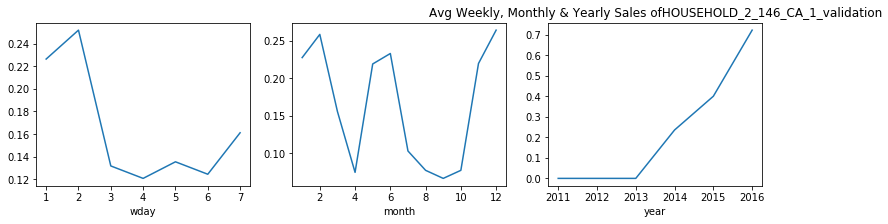

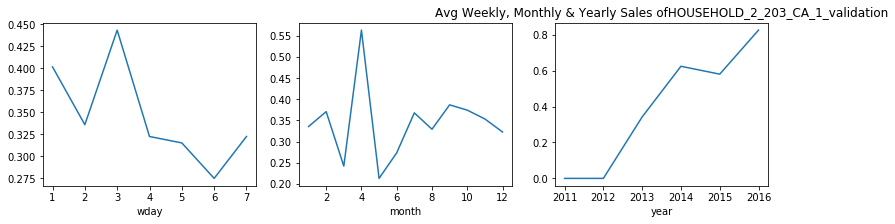

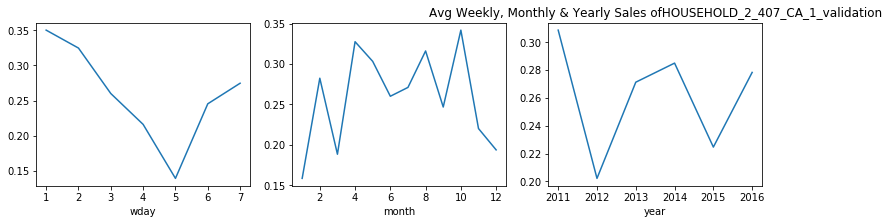

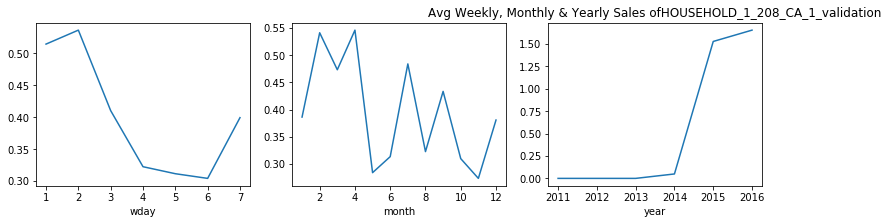

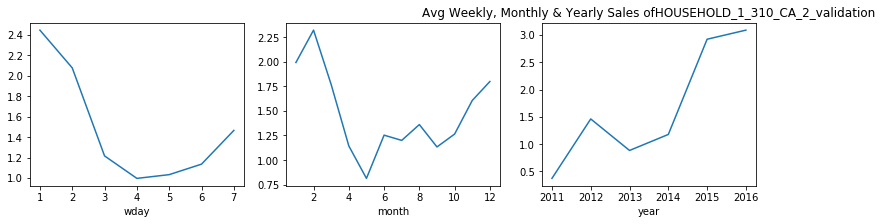

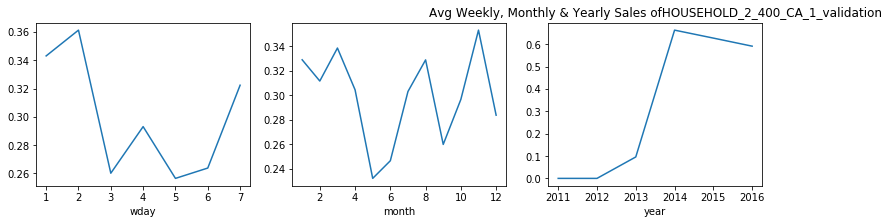

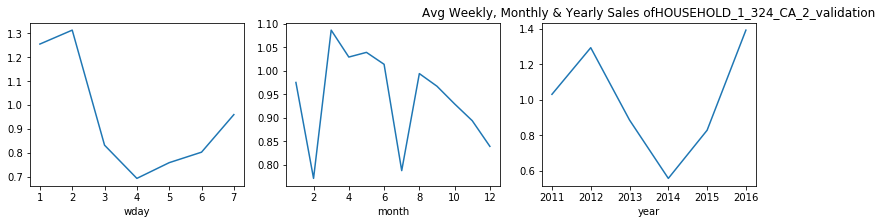

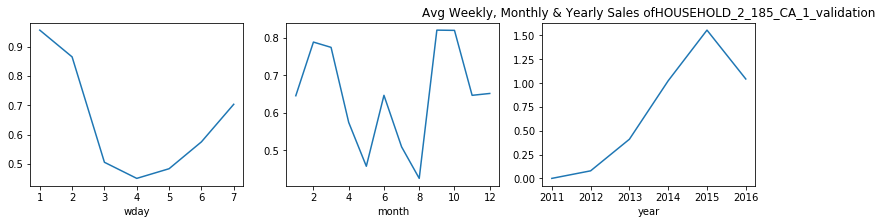

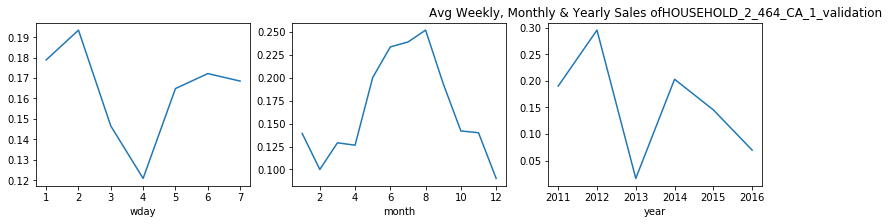

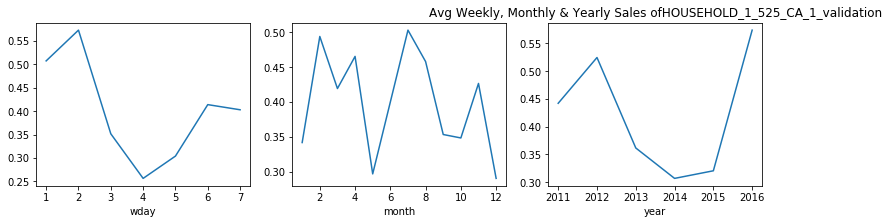

In [38]:
household_pdts=household_df.columns[2:5000]
for i in range(10):
    num=random.choice(list(range(len(hobbies_pdts))))
    fig,axes=plt.subplots(1,3)
    plt.title('Avg Weekly, Monthly & Yearly Sales of'+household_pdts[num])
    household_df.groupby('wday').mean()[household_pdts[num]].plot(ax=axes[0],figsize=(13,3))
    household_df.groupby('month').mean()[household_pdts[num]].plot(ax=axes[1],figsize=(13,3))
    household_df.groupby('year').mean()[household_pdts[num]].plot(ax=axes[2],figsize=(13,3))
    plt.show()

# Analyzing Selling Prices Data

In [41]:
sell_price=pd.read_csv('C:\M5 Forecasting\sell_prices.csv')
sell_price.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


#comment: sort by wm_yr_wk 

In [42]:
sell_price_gr=sell_price.groupby(['store_id','item_id'])['sell_price']
sell_price["pct_diff"] = sell_price_gr.pct_change()
sell_price["sell_price_roll_sd3"] = sell_price_gr.transform(lambda x: x.rolling(3).std())
sell_price["sell_price_roll_sd7"] = sell_price_gr.transform(lambda x: x.rolling(7).std())
sell_price["sell_price_roll_sd14"] = sell_price_gr.transform(lambda x: x.rolling(14).std())
sell_price["sell_price_roll_sd28"] = sell_price_gr.transform(lambda x: x.rolling(28).std())


In [43]:
sell_price.tail()

,store_id,item_id,wm_yr_wk,sell_price,pct_diff,sell_price_roll_sd3,sell_price_roll_sd7,sell_price_roll_sd14,sell_price_roll_sd28
6841116,WI_3,FOODS_3_827,11617,1.0,0.0,0.0,0.0,0.0,0.0
6841117,WI_3,FOODS_3_827,11618,1.0,0.0,0.0,0.0,0.0,0.0
6841118,WI_3,FOODS_3_827,11619,1.0,0.0,0.0,0.0,0.0,0.0
6841119,WI_3,FOODS_3_827,11620,1.0,0.0,0.0,0.0,0.0,0.0
6841120,WI_3,FOODS_3_827,11621,1.0,0.0,0.0,0.0,0.0,0.0


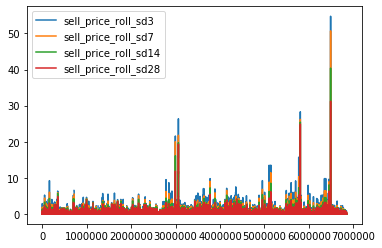

In [44]:
sell_price[['sell_price_roll_sd3','sell_price_roll_sd7','sell_price_roll_sd14','sell_price_roll_sd28']].plot()

For rolling window7, 14 and 28 the results seem to overlap almost completely. Hence, we will only consider 'sell_price_roll_sd3' and 'sell_price_roll_sd7' for the purpose of model training

In [45]:
#cumulative min-max feature

sell_price["sell_price_cumrel"]=(sell_price_gr.shift(0)-sell_price_gr.cummin())/(1 + sell_price_gr.cummax()-sell_price_gr.cummin())
sell_price.tail()

,store_id,item_id,wm_yr_wk,sell_price,pct_diff,sell_price_roll_sd3,sell_price_roll_sd7,sell_price_roll_sd14,sell_price_roll_sd28,sell_price_cumrel
6841116,WI_3,FOODS_3_827,11617,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6841117,WI_3,FOODS_3_827,11618,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6841118,WI_3,FOODS_3_827,11619,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6841119,WI_3,FOODS_3_827,11620,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6841120,WI_3,FOODS_3_827,11621,1.0,0.0,0.0,0.0,0.0,0.0,0.0


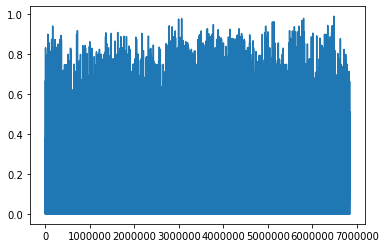

In [46]:
sell_price["sell_price_cumrel"].plot()

# Sales Data

In [47]:
sales_train_valid_pd.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


# Denoising the Sales Data

From the sales plots of invidual products we saw that the sales changes rapidly. This is because the sales of a product on a day depend on multiple factors. So, let us try denoising our data and see if we are able to find anything intresesting.

The basic idea behind wavelet denoising, or wavelet thresholding, is that the wavelet transform leads to a sparse representation for many real-world signals and images. What this means is that the wavelet transform concentrates signal and image features in a few large-magnitude wavelet coefficients. Wavelet coefficients which are small in value are typically noise and you can "shrink" those coefficients or remove them without affecting the signal or image quality. After you threshold the coefficients, you reconstruct the data using the inverse wavelet transform.

For wavelet denoising we require the the library pywt.

Here we will use wavelet denoising. For deciding the threshold of denoising we will use Mean Absolute Deviation

Text(0.5, 1.0, 'Sales Data Before Wavelet Denoising for HOUSEHOLD_1_118_CA_3_validation ')

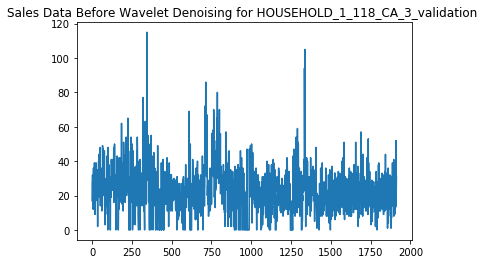

In [93]:
#code referece: https://www.kaggle.com/tarunpaparaju/m5-competition-eda-models/output

plt.plot(example3['HOUSEHOLD_1_118_CA_3_validation'])
item_sales=example3['HOUSEHOLD_1_118_CA_3_validation']
coeff = pywt.wavedec(item_sales, 'db4', mode="per")
mean_coeff=np.mean([abs(ele-np.mean(item_sales)) for ele in item_sales])
sigma = (1/0.6745)*mean_coeff
threshhold=sigma*np.sqrt(2*np.log(len(item_sales)))
coeff[1:] = (pywt.threshold(i, value=threshhold, mode='hard') for i in coeff[1:])
item_sales_wavelet_decomp=pywt.waverec(coeff, 'db4', mode='per')
plt.title('Sales Data Before Wavelet Denoising for HOUSEHOLD_1_118_CA_3_validation ')

Text(0.5, 1.0, 'Sales Data After Wavelet Denoising for HOUSEHOLD_1_118_CA_3_validation ')

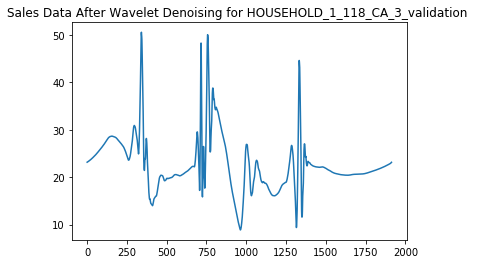

In [94]:
plt.plot(item_sales_wavelet_decomp)
plt.title('Sales Data After Wavelet Denoising for HOUSEHOLD_1_118_CA_3_validation ')

Text(0.5, 1.0, 'Sales Data Before Wavelet Denoising for HOBBIES_1_234_CA_3_validation ')

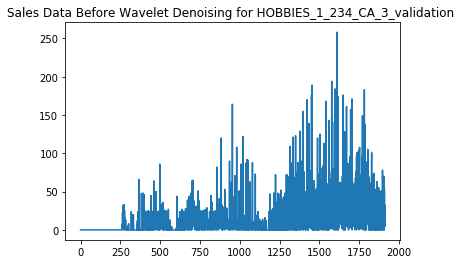

In [96]:
plt.plot(example2['HOBBIES_1_234_CA_3_validation'])
item_sales=example2['HOBBIES_1_234_CA_3_validation']
coeff = pywt.wavedec(item_sales, 'db4', mode="per")
mean_coeff=np.mean([abs(ele-np.mean(item_sales)) for ele in item_sales])
sigma = (1/0.6745)*mean_coeff
threshhold=sigma*np.sqrt(2*np.log(len(item_sales)))
coeff[1:] = (pywt.threshold(i, value=threshhold, mode='hard') for i in coeff[1:])
item_sales_wavelet_decomp=pywt.waverec(coeff, 'db4', mode='per')
plt.title('Sales Data Before Wavelet Denoising for HOBBIES_1_234_CA_3_validation ')

Text(0.5, 1.0, 'Sales Data After Wavelet Denoising for HOBBIES_1_234_CA_3_validation ')

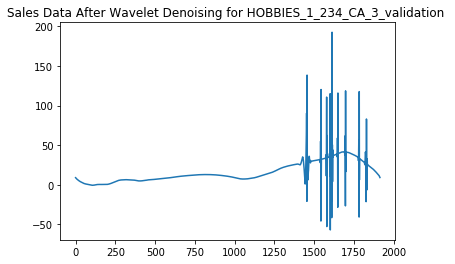

In [97]:
plt.plot(item_sales_wavelet_decomp)
plt.title('Sales Data After Wavelet Denoising for HOBBIES_1_234_CA_3_validation ')

# Observation:
After seeing the denoised data we are more clearly able to see the details. Let us try some other denoising techniques and see if find we any different patterns in our sales dataset.

# Average Smoothing Moving Window:

Let us now try a simple smoothing technique.In this technique we take a fixed window sie and move it along out time series data calculating the average. We also take a stride value so as to leave the intervals accordingly. For example, lets say we take a window size of 20 and stride as 5. Then our first point will be the mean of points from day1 to day 20, the  next will be the mean of points from day5 to day25, then day10 to day30 and so on.

So, let us try this average smoothing on our dataset and see if we find any kind of patterns heres.

Text(0.5, 1.0, 'Sales Data After Average Smoothing for HOUSEHOLD_1_118_CA_3_validation ')

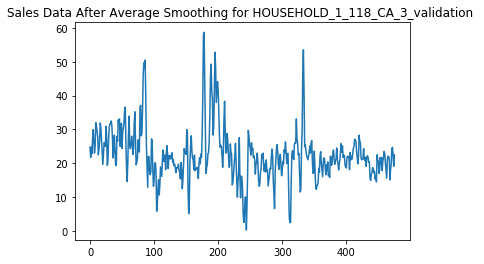

In [101]:
item_sales=example3['HOUSEHOLD_1_118_CA_3_validation']

avg_smoothing=[]
for i in range(0,len(item_sales)-10,4):
    avg_smoothing.append(np.mean(item_sales[i:i+10]))

plt.plot(avg_smoothing)
plt.title('Sales Data After Average Smoothing for HOUSEHOLD_1_118_CA_3_validation ')

Text(0.5, 1.0, 'Sales Data After Average Smoothing for HOBBIES_1_234_CA_3_validation ')

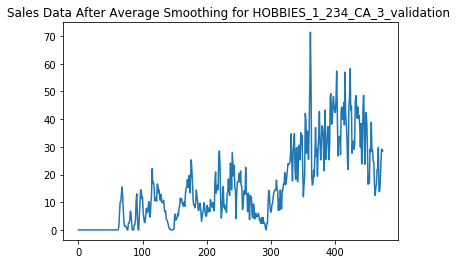

In [102]:
item_sales=example2['HOBBIES_1_234_CA_3_validation']

avg_smoothing=[]
for i in range(0,len(item_sales)-10,4):
    avg_smoothing.append(np.mean(item_sales[i:i+10]))

plt.plot(avg_smoothing)
plt.title('Sales Data After Average Smoothing for HOBBIES_1_234_CA_3_validation ')

# Observations:

We see that the average smoothing does remove some noise but not as effectively as the wavelet decomposition.

In [105]:
temp=sales_train_valid_pd.groupby('store_id').mean().T
temp.head()

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
d_1,1.422434,1.145949,1.554280,0.532962,0.838308,1.263365,0.993768,0.886848,0.739915,1.324369
d_2,1.362742,0.999016,1.583142,0.582814,0.881273,1.291243,0.985897,0.719580,0.630371,1.376845
d_3,0.923582,0.695638,1.241391,0.454575,0.597573,0.895704,0.729747,0.512299,0.661856,1.087898
d_4,1.000656,0.762217,1.387996,0.472286,0.740571,0.968842,0.711381,0.410298,0.827156,1.053132
d_5,0.862578,0.636930,1.251886,0.503772,0.555592,0.817317,0.566087,0.000656,0.385372,0.699246


In [117]:
for ele in temp.columns:
    print(ele,np.mean(temp[ele][:20]))


CA_1 1.0904886848146933
CA_2 0.816054444080026
CA_3 1.4589373565103316
CA_4 0.4895703509347326
TX_1 0.7465890455887176
TX_2 1.0247458183010827
TX_3 0.7833387996064283
WI_1 0.5769760577238439
WI_2 0.6532633650377173
WI_3 1.2475401771072483


In [124]:
moving_avg_dict={}

for ele in temp.columns:
    moving_avg_dict[ele]=[]
    
    for i in range(0,len(temp[ele])-30,10):
        moving_avg_dict[ele].append(np.mean(temp[ele][i:i+20]))
        
movng_store_avg_df=pd.DataFrame.from_dict(moving_avg_dict)

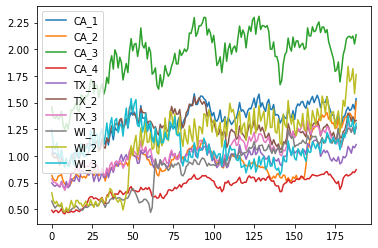

In [125]:
movng_store_avg_df.plot()

# Observations:

From the above plot we can see that the sales for store CA_3 lie above the sales for all other states. The same applies for CA_4 where the sales are lowest. For other sales the patterns are distinguishable to some extent.

One thing that we observe that all these patterns follow a similar trend that repeats itself after sometime. Also, the sales reaches higher value in the graph.

# Box-Plot for Sales for Each Store

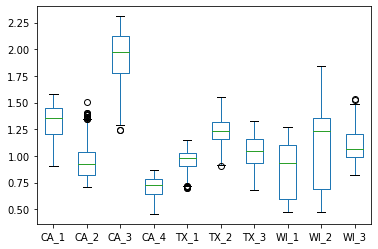

In [127]:
movng_store_avg_df.plot(kind='box')

# Observation:

As we saw from the line-plot, the box plot also shows non-overlapping sales patternf for CA_3 nd CA_4

# Mean Sales of Stores

{'CA_1': 4024.1589127025613, 'CA_2': 2972.020386826973, 'CA_3': 5848.499738630423, 'CA_4': 2145.1521170935703, 'TX_1': 2924.8782017773133, 'TX_2': 3771.240982749608, 'TX_3': 3183.1312075274436, 'WI_1': 2691.6163094615786, 'WI_2': 3420.811291165708, 'WI_3': 3360.0533193936226}


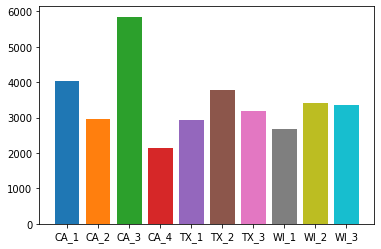

In [136]:
store_sales_sum=sales_train_valid_pd.groupby('store_id').sum().T
mean_store_sales_dict={}

for ele in store_sales_sum.columns:
    mean_store_sales_dict[ele]=np.mean(store_sales_sum[ele])

print(mean_store_sales_dict)
for ele in mean_store_sales_dict:
    plt.bar(ele,mean_store_sales_dict[ele])


# Observations:

From all three plots we see that Wisconsin and Texas has quite an overlapping sales pattern whereas for the state of California it varies widely. Also, the overall higest and lowest sales both belong to California. To see this more closely, let us see the averags rolling window only for the state of California.

# Rolling Average for California

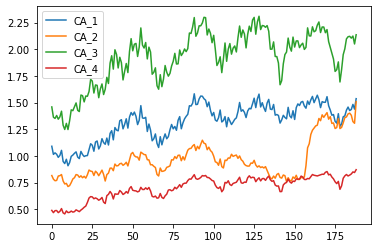

In [148]:
moving_avg_ca=movng_store_avg_df[['CA_1','CA_2','CA_3','CA_4']]

moving_avg_ca.plot()

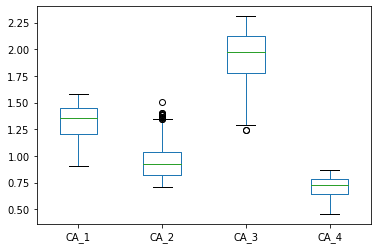

In [152]:
moving_avg_ca.plot(kind='box')

From the above plot we can see that all the 4 stores of California have different sales. No overlapping between the stores and totoally independent of the fact that all of these belong to the same state. This shows high variance for the state of California.

# Rolling Average for Winscosin

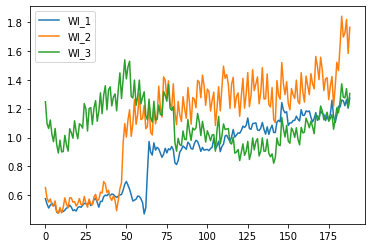

In [150]:
moving_avg_wi=movng_store_avg_df[['WI_1','WI_2','WI_3']]

moving_avg_wi.plot()

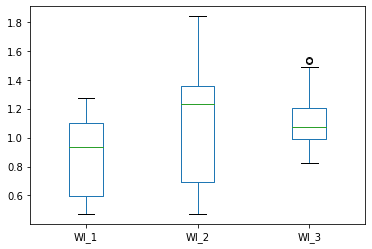

In [151]:
moving_avg_wi.plot(kind='box')

For Winscosin we see that sales for WI_1 AND WI_2 almost overlap. After an interval all three of them have the almost the same pattern and these intersect closely. This shows that sales pattern for the three stores of Wisconsin is quite similar

# Rolling Average for Texas

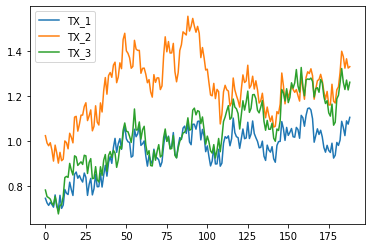

In [153]:
moving_avg_tx=movng_store_avg_df[['TX_1','TX_2','TX_3']]

moving_avg_tx.plot()

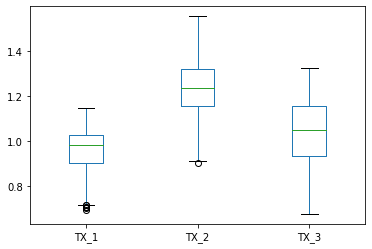

In [154]:
moving_avg_tx.plot(kind='box')

# Observations:

For Texas the states TX_1 and TX_3 have quite smiliar pattrns and intersect a couple of times. But TX_2 lies above them with maximum sales and more disparity as compared to the other two. In the later parts we see that TX_3 is growing rapidly and is approaching towards TX_2. Hence, from this we can conclude that sales for TX_3 increase at the fastest pace.

#cross check titles
1. base-cut models- statistical models at start
2. after this regression models
3. featurization part
4. time series fore-casting retail stores papers